In [1]:
import time 
import getdist
import emcee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from getdist import plots, MCSamples
from scipy.integrate import quad, odeint
from astropy.convolution import Gaussian1DKernel
%matplotlib inline

In [2]:
def calculate_aB(path):
    
    chain = emcee.backends.HDFBackend(path, read_only=True)
    tau = chain.get_autocorr_time()
    burnin = int(2 * np.max(tau))
    thin = int(0.5 * np.min(tau))

    flatchain = chain.get_chain(discard=burnin, flat=True, thin=thin)[:, :2]

    H0_chain = flatchain[:, 0]
    MB_chain = flatchain[:, 1]
    aB = -0.2 * (MB_chain + 25 - 5 * np.log10(H0_chain) +
                 5 * np.log10(2.998e5))

    return aB

In [3]:
IDL = calculate_aB("../Chains/IDL=HFSN+2DBAO+CC/LambdaCDM.h5")
MB_IDL = calculate_aB("../Chains/MB(IDL)+LocalSN/LambdaCDM.h5")
MB_SH0ES_HFSN = calculate_aB("../Chains/MB(SH0ES)+HFSN/LambdaCDM.h5")
MB_SH0ES_localSN = calculate_aB("../Chains/MB(SH0ES)+LocalSN/LambdaCDM.h5")

Omegam_IDL = np.load("aB_Omegam_IDL.npy")

In [4]:
# params = tuple(['a_B'])

# IDL_aB = MCSamples(samples=IDL, names=params, labels=params)

# MB_IDL_aB = MCSamples(samples=MB_IDL, names=params, labels=params)

# MB_SH0ES_HFSN_aB = MCSamples(samples=MB_SH0ES_HFSN,
#                              names=params,
#                              labels=params)

# MB_SH0ES_localSN_aB = MCSamples(samples=MB_SH0ES_localSN,
#                                 names=params,
#                                 labels=params)

# Omegam_IDL_aB = MCSamples(samples=Omegam_IDL, names=params, labels=params)

In [5]:
k = Gaussian1DKernel(4)


def Gaussian_processing(chain, bins):
    prob, aB = np.histogram(chain, bins=bins, range=None)
    prob = np.convolve(prob, k, mode='same')
    prob = prob / prob.max()
    return prob, aB[1:]

In [6]:
IDL_probabilitydensity = Gaussian_processing(IDL, 100)

MB_IDL_probabilitydensity = Gaussian_processing(MB_IDL, 100)

Omegam_IDL_probabilitydensity = Gaussian_processing(Omegam_IDL, 100)

MB_SH0ES_HFSN_probabilitydensity = Gaussian_processing(MB_SH0ES_HFSN, 100)

MB_SH0ES_localSN_probabilitydensity = Gaussian_processing(
    MB_SH0ES_localSN, 100)

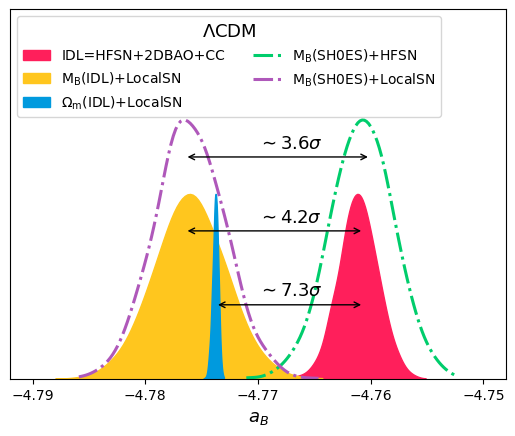

In [7]:
plt.fill_between(IDL_probabilitydensity[1], IDL_probabilitydensity[0], 
                 y2=0, color='#FF1F5B', alpha=1)

plt.fill_between(MB_IDL_probabilitydensity[1], MB_IDL_probabilitydensity[0],
                 y2=0, color='#FFC61E', alpha=1)

plt.fill_between(Omegam_IDL_probabilitydensity[1],
                 Omegam_IDL_probabilitydensity[0],
                 y2=0, color='#009ADE', alpha=1)

plt.plot(MB_SH0ES_HFSN_probabilitydensity[1],
         MB_SH0ES_HFSN_probabilitydensity[0] * 1.4,
         color='#00CD6C', lw=2.2, linestyle='-.')

plt.plot(MB_SH0ES_localSN_probabilitydensity[1],
         MB_SH0ES_localSN_probabilitydensity[0] * 1.4,
         color='#AF58BA', lw=2.2, linestyle='-.')

plt.legend(labels=[
    'IDL=HFSN+2DBAO+CC',
    r'$\mathrm{M_B}$(IDL)+LocalSN',
    r'$\mathrm{\Omega_m}$(IDL)+LocalSN',
    r'$\mathrm{M_B}$(SH0ES)+HFSN',
    r'$\mathrm{M_B}$(SH0ES)+LocalSN',
],
           loc='upper left',
           title='$\Lambda$CDM',
           fontsize=10,
           title_fontsize=13,
           ncol=2)

plt.annotate(text='',
             xy=(-4.7765, 0.8),
             xytext=(-4.7606, 0.8),
             arrowprops=dict(arrowstyle='<->'))
plt.annotate(text='$\sim4.2\sigma$',
             xy=(-4.77, 0.85),
             xytext=(-4.77, 0.85),
             arrowprops=None,
             fontsize=13)

plt.annotate(text='',
             xy=(-4.7738, 0.4),
             xytext=(-4.7606, 0.4),
             arrowprops=dict(arrowstyle='<->'))
plt.annotate(text='$\sim7.3\sigma$',
             xy=(-4.77, 0.45),
             xytext=(-4.77, 0.45),
             arrowprops=None,
             fontsize=13)

plt.annotate(text='',
             xy=(-4.7765, 1.2),
             xytext=(-4.76, 1.2),
             arrowprops=dict(arrowstyle='<->'))
plt.annotate(text='$\sim3.6\sigma$',
             xy=(-4.77, 1.25),
             xytext=(-4.77, 1.25),
             arrowprops=None,
             fontsize=13)

plt.xticks(np.arange(-4.8, -4.7, 0.01), fontsize=10)
plt.yticks([])
plt.xlim(-4.792, -4.748)
plt.ylim(0, 2)
plt.xlabel("$a_B$", fontsize=13)
plt.savefig("LCDM-aB-probility.pdf", dpi=1000, bbox_inches='tight')